# Used car price prediction with ML algorithms

The following project aims to analyze a dataset containing data about audi cars to extract useful insights and develop a ML algorithm to predict the price of a used audi car given some features.<br>
The Project is strucured as follows:<br>

-Data Cleaning<br>
-Exploratory Data Analysis<br>
-Data Preparation for ML modeling<br>
-ML modeling<br>
-Results Summary<br>
-Feature Importance analysis with XGBOOST and SHAP


For prediction, LightGBM and XGBoost performed very similarly, with R2=96% and RMSE around 2200$


# Main Results Summary Dashboard:

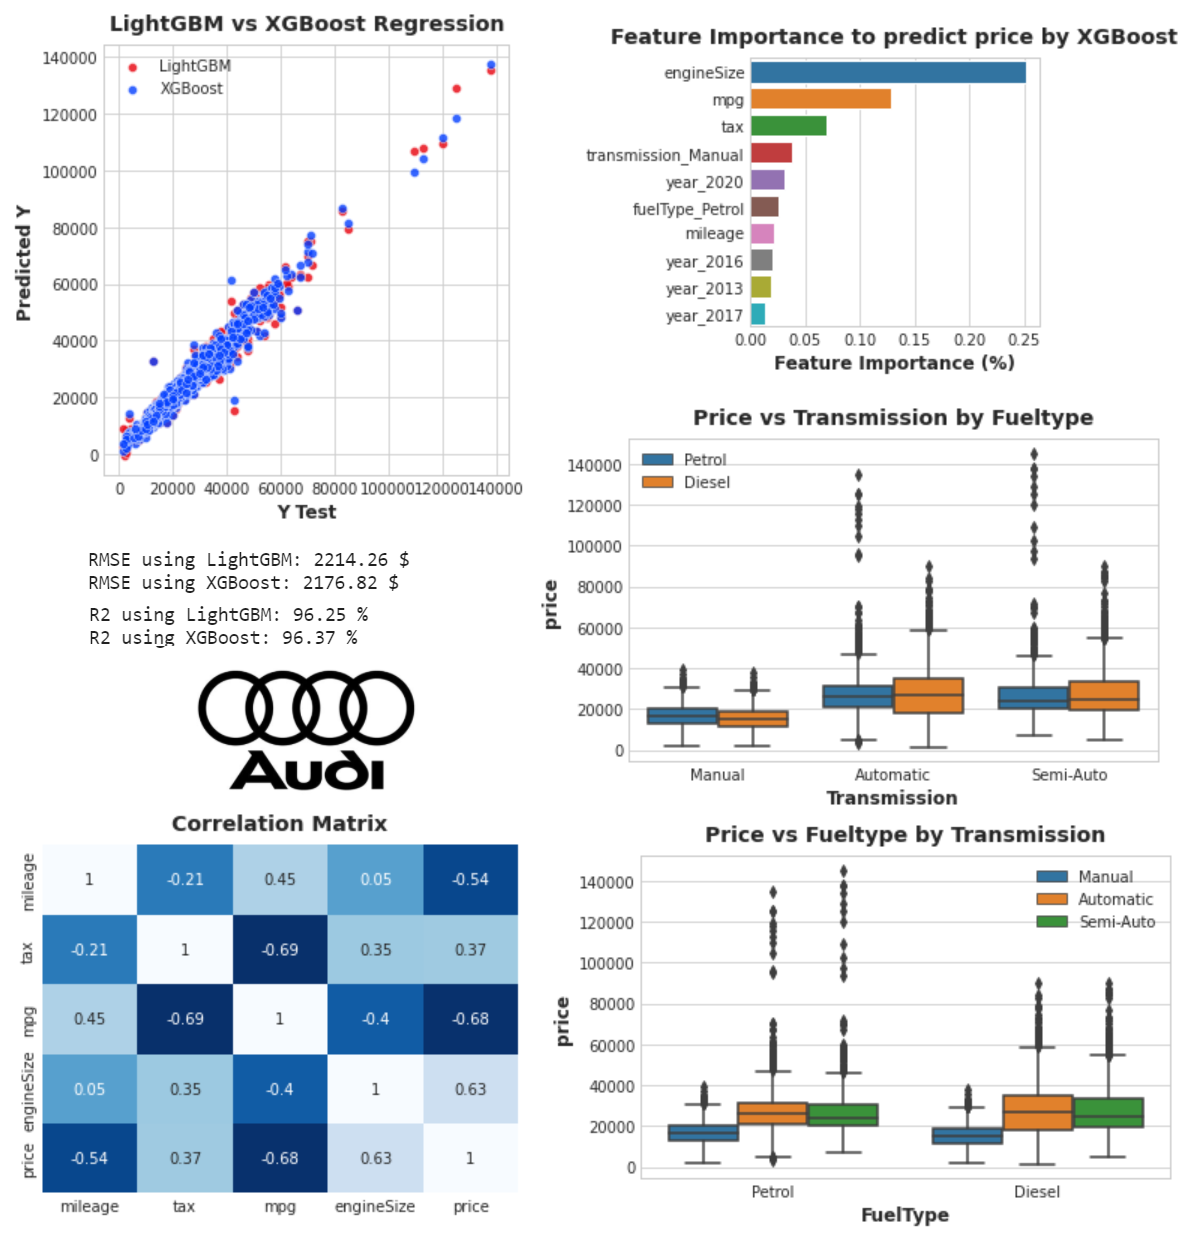

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/used-car-dataset-ford-and-mercedes/cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean cclass.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/audi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/toyota.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/skoda.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/ford.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vauxhall.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/bmw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/vw.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/hyundi.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/unclean focus.csv
/kaggle/input/used-car-dataset-ford-and-mercedes/merc.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import xgboost as xgb
import lightgbm as lgbm
import shap

from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style("whitegrid")
sns.despine()
sns.set_color_codes('bright')

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

2021-10-13 21:22:55.350684: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-13 21:22:55.350757: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<Figure size 432x288 with 0 Axes>

In [3]:
df=pd.read_csv('/kaggle/input/used-car-dataset-ford-and-mercedes/audi.csv',skipinitialspace=True)

During the model deployment, I noticed that the values in the model columns had a blank space in front. For this reason, I decided to add "skipinitialspace=True" during the creation of the dataframe.

In [4]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


I will reorder the columns to group the categorical variables first and then the numerical ones

In [5]:
df=df[['model','year','transmission','fuelType','mileage','tax','mpg','engineSize','price']]

In [6]:
df.head(10)

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300
5,A1,2016,Automatic,Petrol,32260,30,58.9,1.4,13900
6,A6,2016,Automatic,Diesel,76788,30,61.4,2.0,13250
7,A4,2016,Manual,Diesel,75185,20,70.6,2.0,11750
8,A3,2015,Manual,Petrol,46112,20,60.1,1.4,10200
9,A1,2016,Manual,Petrol,22451,30,55.4,1.4,12000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   transmission  10668 non-null  object 
 3   fuelType      10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   tax           10668 non-null  int64  
 6   mpg           10668 non-null  float64
 7   engineSize    10668 non-null  float64
 8   price         10668 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


In [8]:
df['year'] = df['year'].astype(object)

It looks like there are no missing values.

# Exploratory Data Analysis

In [9]:
df_clean = df.copy()

First, we need to understand if excluding 'mileage', which heavily depends how much a car has been used, the other features uniquely identify a car or not.

In [10]:
df_models=df.drop(['price','mileage','tax'], axis=1).drop_duplicates().sort_values(by=['model','year','fuelType'])
df_models.head()

,model,year,transmission,fuelType,mpg,engineSize
10632,A1,2010,Automatic,Petrol,53.3,1.4
9625,A1,2011,Manual,Diesel,70.6,1.6
9791,A1,2011,Manual,Petrol,53.3,1.4
7950,A1,2012,Manual,Diesel,74.3,1.6
8101,A1,2012,Manual,Diesel,68.9,2.0


Apparently the mpg and engineSize are not uniquely identified by the car model, year, transmission and fuelType.

## Numerical features first analysis

To analyze the numerical features, we will first define a function thats plots the hisogram and boxplots of all the numerical features.

In [11]:
def num_plots(df):
    fig, ax = plt.subplots(2,5, figsize=(15,8))
    ax[0,0].hist(df['mileage'],density = True, bins = 20)
    ax[0,0].set_title('mileage hist')
    ax[0,1].hist(df['tax'],density = True, bins = 20)
    ax[0,1].set_title('tax hist')
    ax[0,2].hist(df['mpg'],density = True, bins = 20)
    ax[0,2].set_title('mpg hist')
    ax[0,3].hist(df['engineSize'],density = True, bins = 20)
    ax[0,3].set_title('engineSize hist')
    ax[0,4].hist(df['price'],density = True, bins = 20)
    ax[0,4].set_title('price hist')

    ax[1,0].boxplot(df['mileage'])
    ax[1,0].set_title('mileage boxplot')
    ax[1,1].boxplot(df['tax'])
    ax[1,1].set_title('tax boxplot')
    ax[1,2].boxplot(df['mpg'])
    ax[1,2].set_title('mpg boxplot')
    ax[1,3].boxplot(df['engineSize'])
    ax[1,3].set_title('engineSize boxplot')
    ax[1,4].boxplot(df['price'])
    ax[1,4].set_title('price boxplot')
    plt.show()

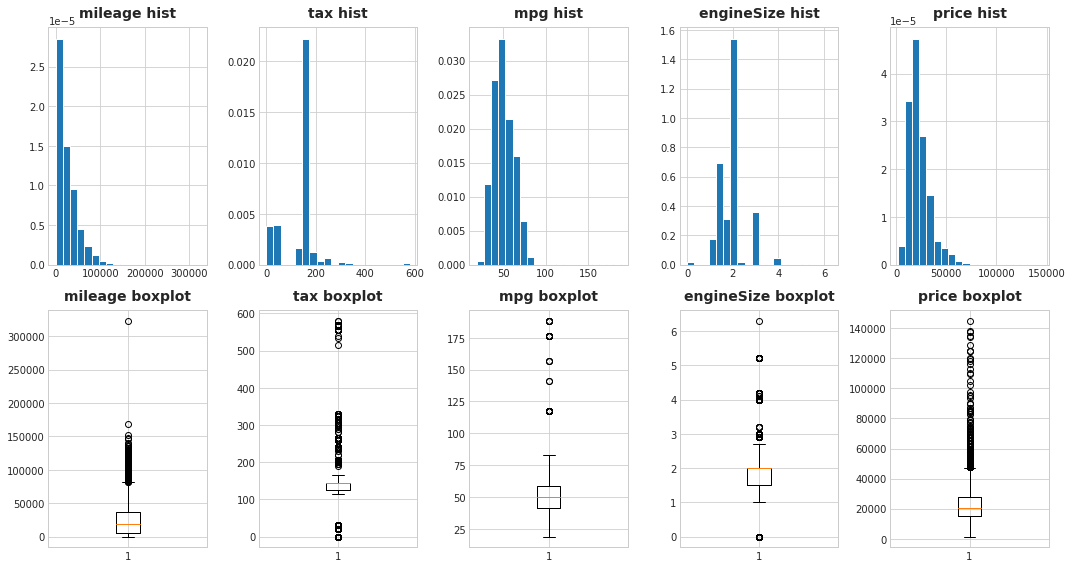

In [12]:
num_plots(df)

From these plots we can see that the numerical features present a so called 'long tail' distribution, with some outliers.

In [13]:
df.describe()

,mileage,tax,mpg,engineSize,price
count,10668.000000,10668.000000,10668.000000,10668.000000,10668.000000
mean,24827.244001,126.011436,50.770022,1.930709,22896.685039
std,23505.257205,67.170294,12.949782,0.602957,11714.841888
min,1.000000,0.000000,18.900000,0.000000,1490.000000
25%,5968.750000,125.000000,40.900000,1.500000,15130.750000
50%,19000.000000,145.000000,49.600000,2.000000,20200.000000
75%,36464.500000,145.000000,58.900000,2.000000,27990.000000
max,323000.000000,580.000000,188.300000,6.300000,145000.000000


By looking at the histograms, boxplots and summary statistics we can have a first glance at the numerical features and say:

- mileage : the mean is around 25k, a too high value due to the presence of the outlier value equals to 323'000 miles. We will remove this outlier immediately.
- tax: the mean is around 126, and similarly to mileage this is due to the presence of some very high values.
- mpg : the mean is around 50, which is compatible with the distribution we can see: it looks almost gaussian, we can remove the extreme values ( over mpg=100, and check for normality )
- enginesize: there are some cars with a 0 value, which is impossible. Probably it refers to missing values, which however are very few as we can see from the distribution.
- price: it has a clear long tail behaviour, with some prices over 100'000 $

# Outlier Detection

First, we define a function to plot both the distribution and boxplot to be able to identify outliers more easily.

In [14]:
def plots(df,col):
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    ax[0].hist(df[col])
    ax[0].set_title(col + ' hist')
    ax[1].boxplot(df[col])
    ax[1].set_title(col + ' boxplot')
    plt.show()

We also create a copy of the dataframe, which will store the cleaned version of the dataframe itself

In [15]:
df_clean = df

Before starting the analysis, it could be interesting to check the correlation matrix first !

Text(0.5, 1.0, 'Correlation Matrix')

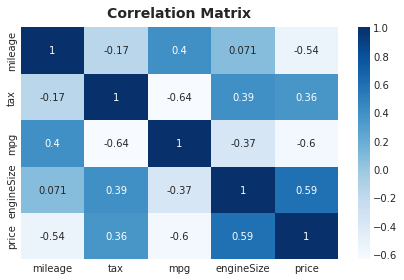

In [16]:
sns.heatmap(df.corr(), cmap='Blues', annot=True)
plt.title('Correlation Matrix')

From the heatmap, we can say the following about the price:<br>
- There is a quite moderate negative correlation (-0.6) between the mpg and the price. This means that cars with high mpg tends to be cheaper.<br>
- There is a quite moderate negative correlation (-0.54) between the mileage and the price. This means that cars with a higher mileage tend to be cheaper.<br>
- There is a small positive correlation (+0.36) also between the tax and the price. Cars with higher tax tends to cost more.
- Finally, there is a moderate positive correlation (0.59) also between the enginesize and the price. Cars with higher enginesize tends to cost more.

Other interesting information not related to the price are:<br>
- There is a moderate positive correlation (0.4) between the mpg and mileage: cars with high mpg tends to have a higher mileage<br>
- There is a quite moderate negative correlation (-0.64) between tax and mpg. Cars with high mpg tends to have lower tax.





# Mileage analysis

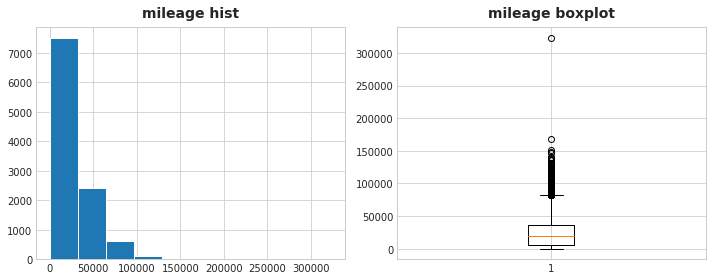

In [17]:
plots(df_clean,'mileage')

In [18]:
df_clean = df_clean[df_clean['mileage'] < 200000]

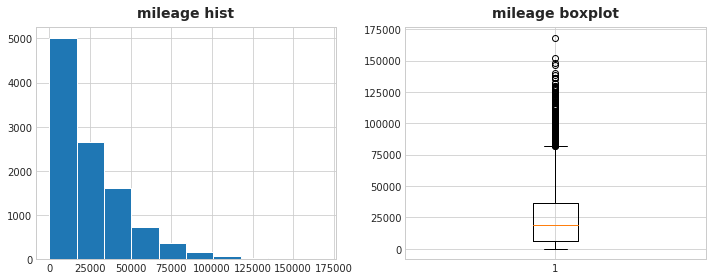

In [19]:
plots(df_clean,'mileage')

There are still some values over 150'000 that we can remove !

In [20]:
df_clean = df_clean[df_clean['mileage'] < 150000]

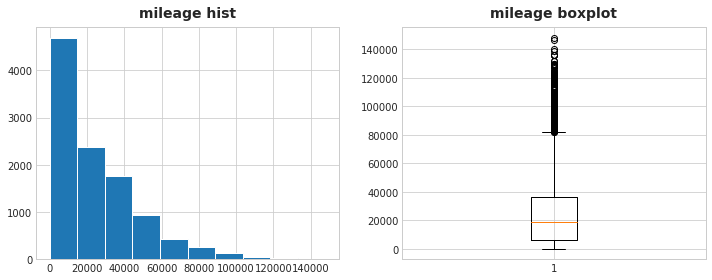

In [21]:
plots(df_clean,'mileage')

In [22]:
print('We removed {} outliers!'.format(len(df) - len(df_clean)))

We removed 3 outliers!


Which are the cars we removed?

In [23]:
df[df['mileage'] >= 150000]

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
7404,A3,2009,Manual,Diesel,152034,150,55.4,1.9,2490
9690,Q5,2011,Manual,Diesel,168017,200,42.1,2.0,6195
9822,A6,2008,Manual,Diesel,323000,200,44.1,2.0,2490


These cars, with a very high mileage value, also have a very high value of tax and a very low value of price. We could understand this behaviour also from the correlation matrix.

# Miles per Gallon (MPG) Analysis

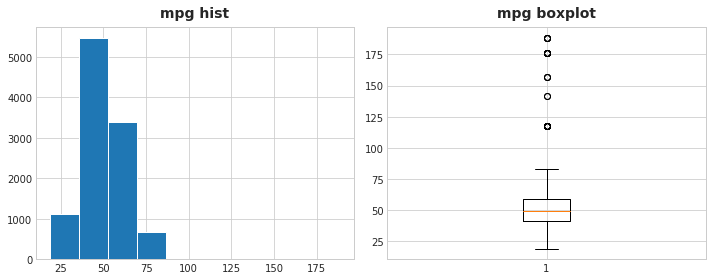

In [24]:
plots(df_clean, 'mpg')

It looks like there are some cars with a mpg value higher than 100, which are those cars?

In [25]:
df_clean[df_clean['mpg']>100]

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
864,A3,2020,Semi-Auto,Hybrid,2165,135,141.3,1.4,31990
1104,Q5,2019,Automatic,Hybrid,6565,135,117.7,2.0,44990
1648,Q5,2020,Semi-Auto,Hybrid,3500,135,117.7,2.0,46450
2550,Q7,2017,Semi-Auto,Hybrid,66477,140,156.9,3.0,32998
3106,A3,2015,Semi-Auto,Hybrid,28294,0,188.3,1.4,14981
3489,Q5,2019,Semi-Auto,Hybrid,2010,135,117.7,2.0,44991
3689,Q5,2020,Semi-Auto,Hybrid,4000,135,117.7,2.0,46000
4095,Q5,2019,Automatic,Hybrid,10000,135,117.7,2.0,45490
4261,A3,2015,Automatic,Hybrid,14000,0,188.3,1.4,17990
4314,Q5,2019,Semi-Auto,Hybrid,8700,135,117.7,2.0,44495


It looks the majority of these cars are A3, Q5 or Q7. In particular they all have Automatic or semi automatic transmission and most of them have Hybrid fueltype.

We will analyze all the hybrid cars present in the dataframe.

In [26]:
df_hyb = df[df['fuelType'] == 'Hybrid']

In [27]:
print('There are {} Hybrid cars in the dataset, which are {} % of the total cars'.format(len(df_hyb),len(df_hyb)/len(df)))

There are 28 Hybrid cars in the dataset, which are 0.0026246719160104987 % of the total cars


Indeed, there are very few hybrid cars in the dataset. We will see if all of them will be removed after the outlier cleaning.

We continue with the outlier removal from the mpg column.

In [28]:
df_clean = df_clean[df_clean['mpg'] < 100]

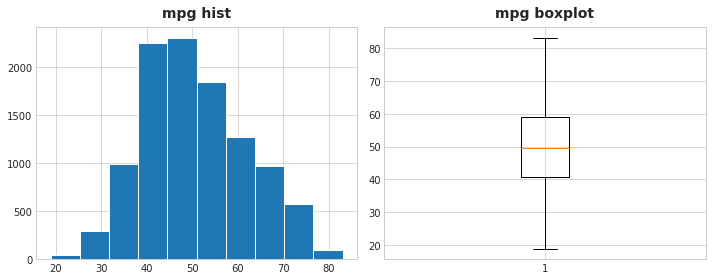

In [29]:
plots(df_clean,'mpg')

Great, the mpg column looks very clean now. Moreover, the distribution of mpg looks somewhat normal, let's check how 'normal' it is !

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


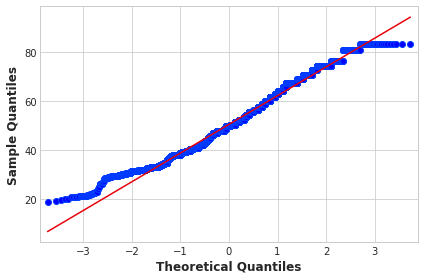

In [30]:
qqplot(df_clean.mpg, line='s')
plt.show()

In [31]:
stat, p = normaltest(df_clean.mpg)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=299.263, p=0.000
Sample does not look Gaussian (reject H0)


**The distributions does not seem to be normal with 95% confidence.** <br>
In particular, from the QQplot we can see that the problem lies mostly in the tails of the distribution. The distribution is still a bit right skewed.

In [32]:
print('We removed {} outliers!'.format(len(df) - len(df_clean)))

We removed 36 outliers!


# Tax Analysis

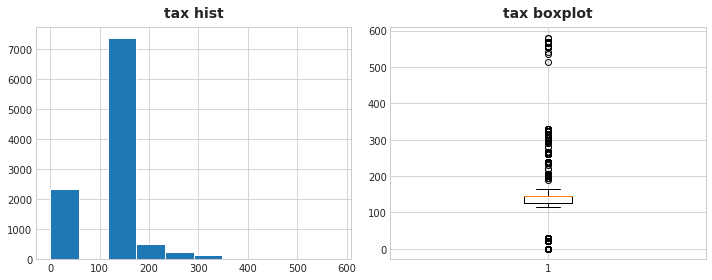

In [33]:
plots(df_clean, 'tax')

It looks there are two outlier clusters: tax values over 500 and lower than 100. We will analyze these two clusters

## High Tax value

In [34]:
df_tax_high = df_clean[df_clean['tax'] > 500]

In [35]:
len(df_tax_high)

40

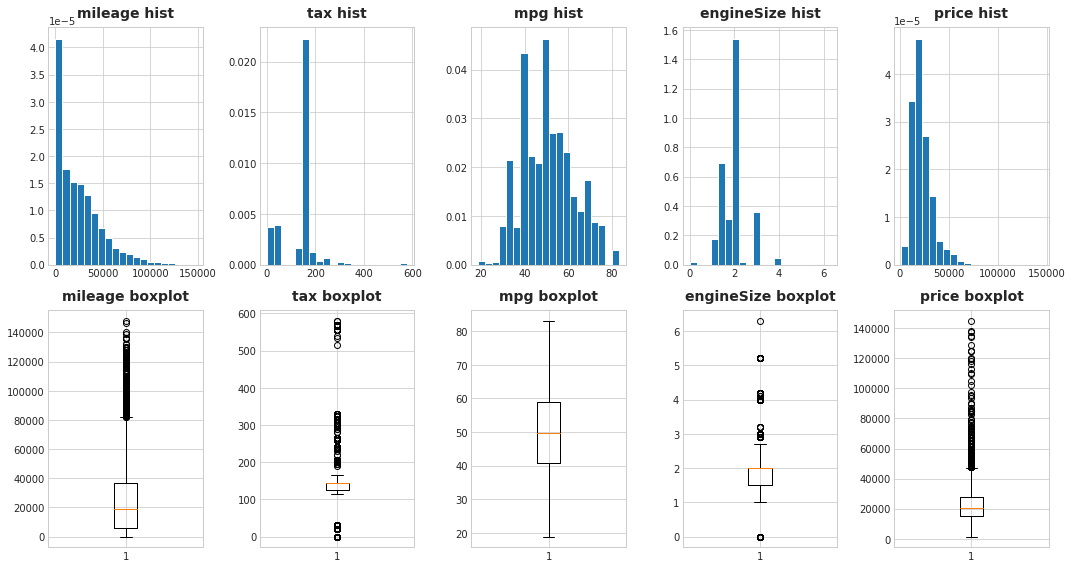

In [36]:
num_plots(df_clean)

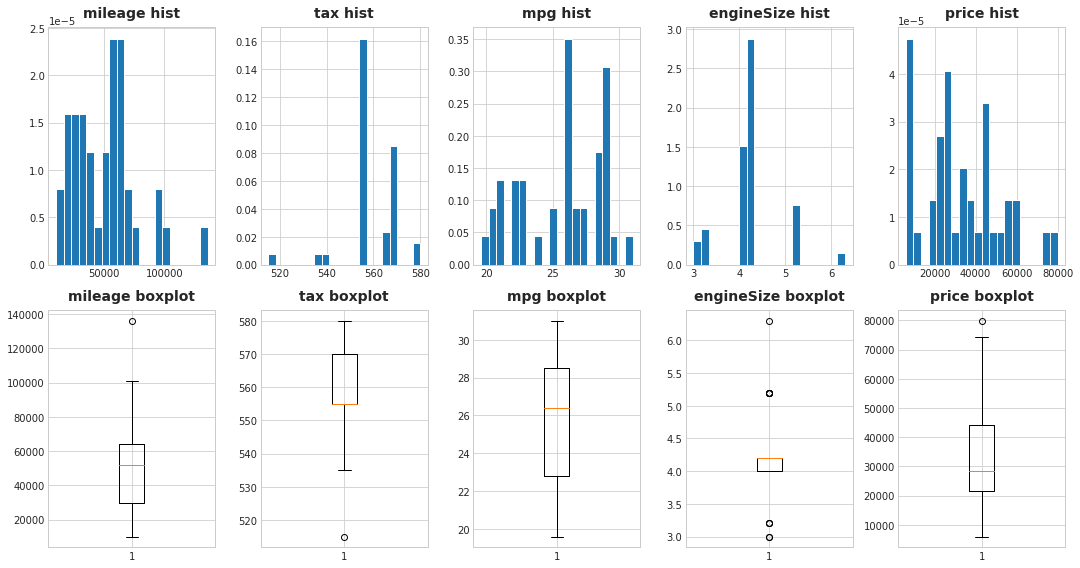

In [37]:
num_plots(df_tax_high)

It looks like that these cars also have quite high values for enginesize (identified by outliers in the df_clean's boxplot).

We can remove these 40 outliers !

In [38]:
df_clean = df_clean[df_clean['tax'] < 500]

## Low tax cars:

In [39]:
df_tax_low =  df_clean[df_clean['tax'] < 100]

In [40]:
len(df_tax_low)

2353

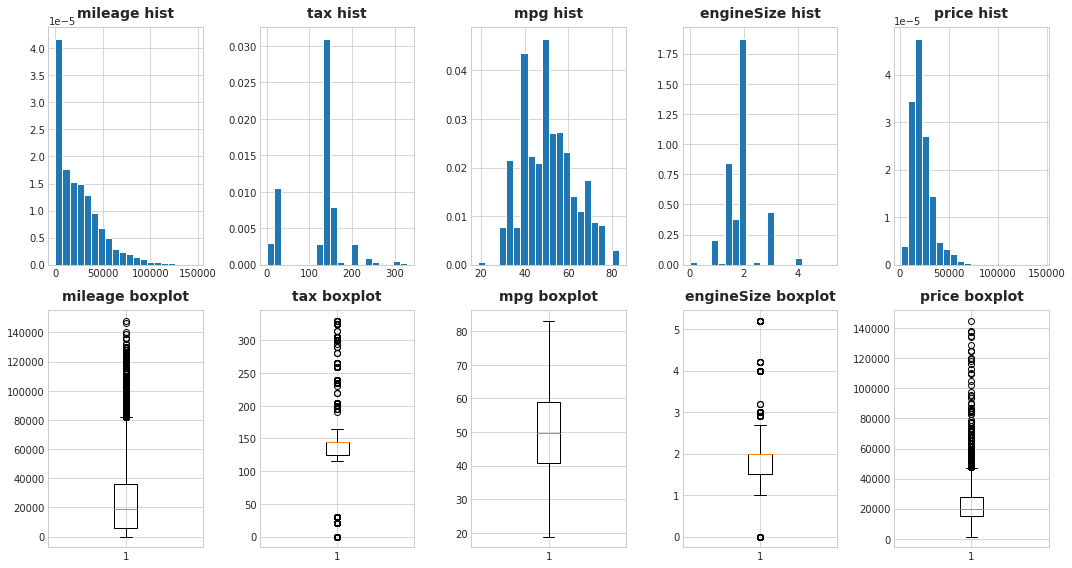

In [41]:
num_plots(df_clean)

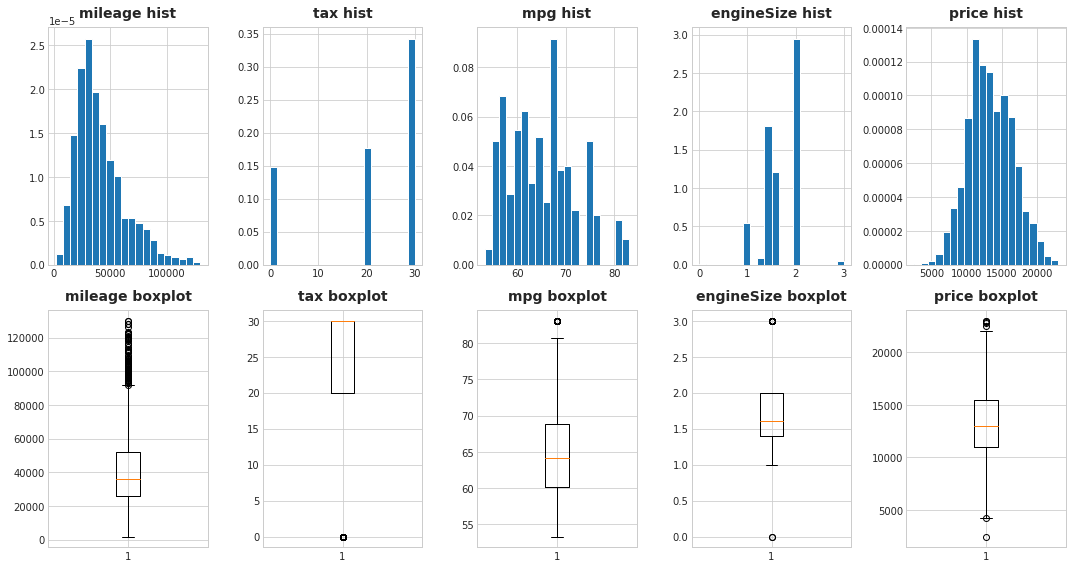

In [42]:
num_plots(df_tax_low)

It looks like these cars with low values of tax have small price (kinda gaussian with mean around 12000$)

In particular, these values are not particularly different from others besides the low value of tax. We will keep them.

# Enginesize Analysis

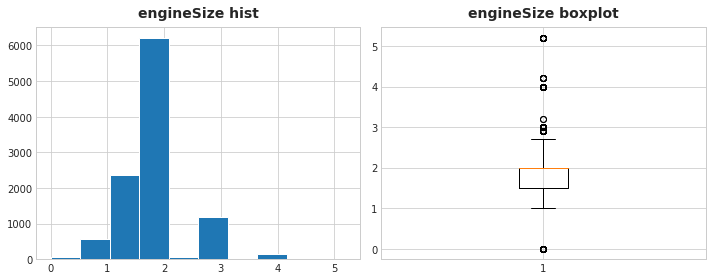

In [43]:
plots(df_clean, 'engineSize')

It looks like there are cars with enginesize=0 and few cars with enginesize over 5, we will investigate more!

In [44]:
df_size_small = df_clean[df_clean['engineSize'] == 0]

In [45]:
df_size_small

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
7506,Q3,2019,Automatic,Diesel,1500,145,47.1,0.0,32788
7516,Q3,2020,Manual,Petrol,1500,145,40.9,0.0,29944
7517,Q3,2020,Automatic,Diesel,1500,145,47.1,0.0,33333
7518,Q3,2020,Automatic,Petrol,1500,145,32.5,0.0,29944
7519,Q3,2020,Automatic,Petrol,1500,145,30.7,0.0,37990
7542,Q3,2019,Manual,Petrol,2001,145,40.4,0.0,31888
7545,Q2,2020,Automatic,Petrol,1500,145,42.2,0.0,24988
7546,A3,2017,Manual,Petrol,7110,30,60.1,0.0,17390
7591,Q5,2019,Automatic,Diesel,45,145,39.2,0.0,33390
7598,A3,2019,Manual,Petrol,1500,145,47.1,0.0,22000


In [46]:
len(df_size_small)

54

In [47]:
df_size_small['model'].value_counts()

Q3     27
A3      7
Q2      6
S4      3
A5      3
Q5      2
SQ5     2
TT      2
A4      1
A1      1
Name: model, dtype: int64

In [48]:
df_q3 = df_clean[df_clean['model']=='Q3']

In [49]:
len(df_q3)

1417

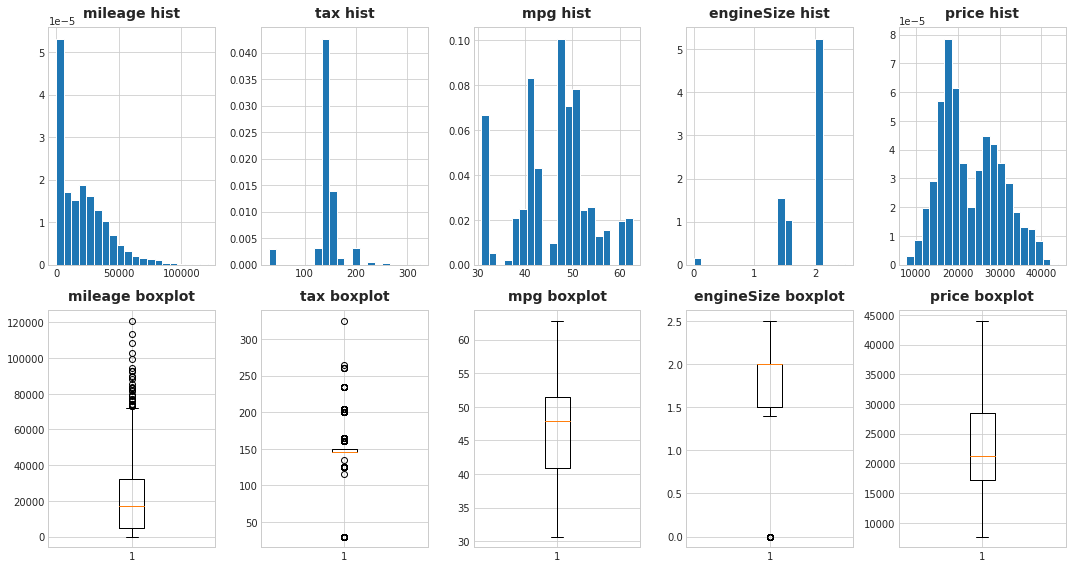

In [50]:
num_plots(df_q3)

In the case of Q3 it looks like these samples with enginesize=0 are outliers. For this reason we will consider them outliers also for the other models and drop them.

In [51]:
df_clean= df_clean[df_clean['engineSize'] > 0]

In [52]:
df_size_big = df_clean[df_clean['engineSize'] > 5]

In [53]:
df_size_big

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
1646,R8,2019,Semi-Auto,Petrol,4000,145,21.4,5.2,129000
2255,R8,2020,Semi-Auto,Petrol,70,145,21.1,5.2,137995
3359,R8,2019,Automatic,Petrol,100,145,24.1,5.2,125000
3367,R8,2019,Automatic,Petrol,1000,145,32.8,5.2,135000
3939,R8,2019,Automatic,Petrol,8175,145,21.6,5.2,112990
4179,R8,2019,Semi-Auto,Petrol,10,150,21.4,5.2,137500
4391,R8,2018,Semi-Auto,Petrol,3800,145,23.0,5.2,93950
4742,R8,2019,Automatic,Petrol,11936,145,21.4,5.2,117990
4783,R8,2020,Semi-Auto,Petrol,2000,145,21.1,5.2,145000
4925,R8,2019,Semi-Auto,Petrol,500,145,21.4,5.2,125000


In [54]:
len(df_size_big)

18

It looks like all of these cars with a very big engine are Audi R8!

In [55]:
df_clean[df_clean['model']=='R8']

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
1646,R8,2019,Semi-Auto,Petrol,4000,145,21.4,5.2,129000
2255,R8,2020,Semi-Auto,Petrol,70,145,21.1,5.2,137995
3359,R8,2019,Automatic,Petrol,100,145,24.1,5.2,125000
3367,R8,2019,Automatic,Petrol,1000,145,32.8,5.2,135000
3939,R8,2019,Automatic,Petrol,8175,145,21.6,5.2,112990
4179,R8,2019,Semi-Auto,Petrol,10,150,21.4,5.2,137500
4391,R8,2018,Semi-Auto,Petrol,3800,145,23.0,5.2,93950
4742,R8,2019,Automatic,Petrol,11936,145,21.4,5.2,117990
4783,R8,2020,Semi-Auto,Petrol,2000,145,21.1,5.2,145000
4925,R8,2019,Semi-Auto,Petrol,500,145,21.4,5.2,125000


Ok, all of the R8 in this dataset have this big engine. We will keep this data.

In [56]:
print('So far we have removed {} outliers !'.format(len(df)-len(df_clean)))

So far we have removed 130 outliers !


# Price Analysis

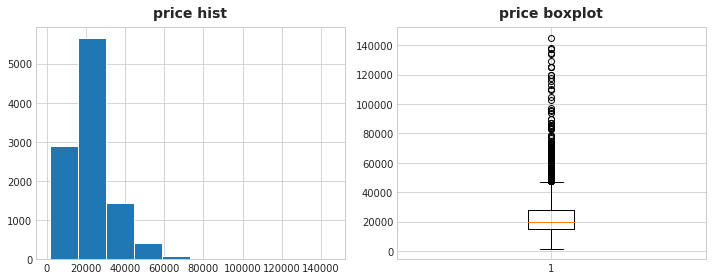

In [57]:
plots(df_clean,'price')

The distribution looks like a 'long tail'. Using a log transformation can we normalize it?

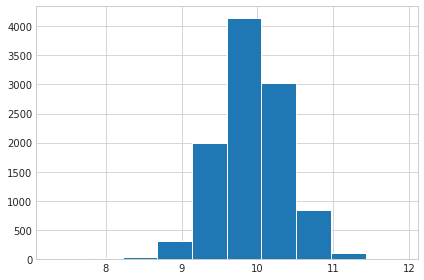

In [58]:
plt.hist(np.log(df_clean['price']))
plt.show()

In [59]:
price_log = np.log(df_clean['price'])

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.


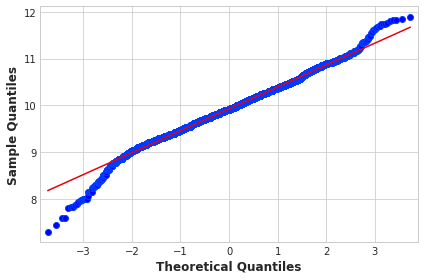

In [60]:
qqplot(price_log, line='s')
plt.show()

In [61]:
stat, p = normaltest(price_log)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=224.328, p=0.000
Sample does not look Gaussian (reject H0)


The distribution is not normal but close enough. We will see if we can improve the ML predicting performance by log transforming the price variable.
EDIT: By log transforming 'price', the prediction performance of both XGBoost and LightGBM seems to be inferior. This is probably due to the fact that tree-based algorithms such as XGBoost andLightGBM do not get particular benefits from this transformation.

## Multivariate Outlier Detection

Text(0.5, 1.0, 'Correlation Matrix')

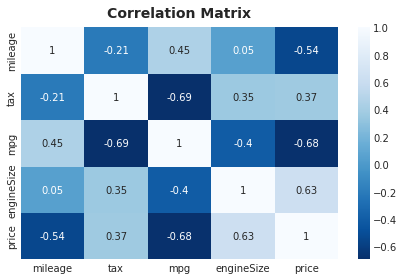

In [62]:
sns.heatmap(df_clean.corr(), cmap='Blues_r', annot=True)
plt.title('Correlation Matrix')

We should investigate Multivariate outliers for the features with high correlations:<br>
- price-mpg<br>
- price-enginesize<br>
- price-mileage<br>
- tax-mpg<br>

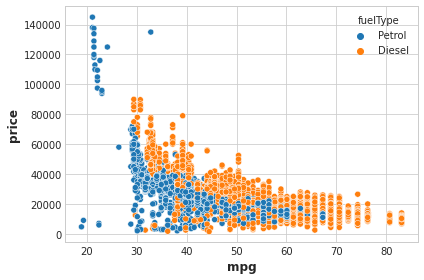

In [63]:
sns.scatterplot(y='price', x='mpg', data=df_clean, hue='fuelType')
plt.show()

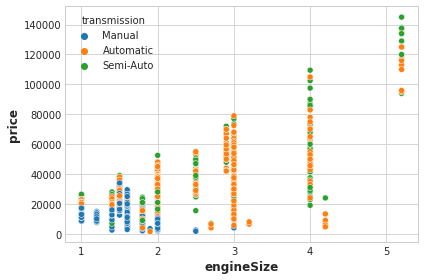

In [64]:
sns.scatterplot(y='price', x='engineSize', data=df_clean, hue='transmission')
plt.show()

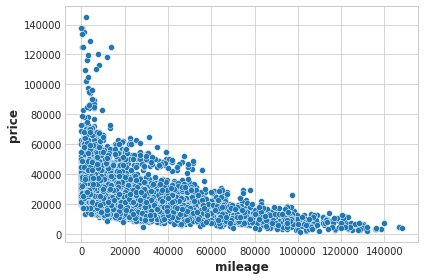

In [65]:
sns.scatterplot(y='price', x='mileage', data=df_clean)
plt.show()

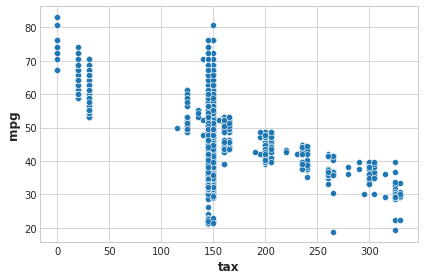

In [66]:
sns.scatterplot(y='mpg', x='tax', data=df_clean)
plt.show()

We cannot see particular outliers that can potentially degrade the ML algorithm performance. We won't drop any more values.

In [67]:
print('In total we removed {} outliers!'.format(len(df)-len(df_clean)))

In total we removed 130 outliers!


In [68]:
print('Percentage of removed outliers with respect to dataframe size: {}%'.format(np.round((len(df)-len(df_clean))/len(df),3)))

Percentage of removed outliers with respect to dataframe size: 0.012%


# How is fueltype related to price?

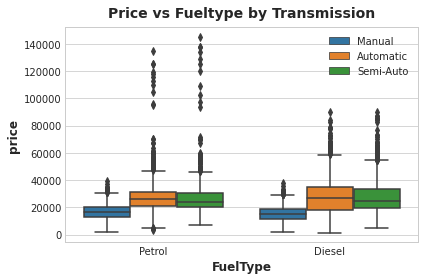

In [69]:
sns.boxplot(x='fuelType', y='price', data=df_clean, hue='transmission');
plt.xlabel('FuelType');
plt.legend(loc='upper right')
plt.title('Price vs Fueltype by Transmission');

We can see that cars Automatic and Semi-Auto transmission are more expensive, while cars with a manual transimission are cheaper.

# How is transmission related to price?

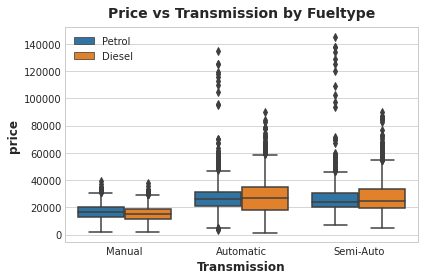

In [70]:
sns.boxplot(x='transmission', y='price', data=df_clean, hue='fuelType');
plt.xlabel('Transmission');
plt.title('Price vs Transmission by Fueltype');
plt.legend(loc='upper left')

From this plot it is possible to assert that cars with an Automatic or Semi-Automatic transmission are on average more expensive than cars with manual transmission. In particular, it is possible to say that while cars with manual transmission have a more similar price, cars with automatic or semi-auto transmission have a wider range of prices.

# Data Preparation for modeling

In [71]:
df_clean.head()

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300


In [72]:
df_clean.describe()

,mileage,tax,mpg,engineSize,price
count,10538.000000,10538.000000,10538.000000,10538.000000,10538.000000
mean,24748.415544,124.417821,50.613608,1.932909,22801.848928
std,23151.471535,61.826961,11.590642,0.571096,11640.987834
min,1.000000,0.000000,18.900000,1.000000,1490.000000
25%,6000.000000,125.000000,40.900000,1.500000,15000.000000
50%,19000.000000,145.000000,49.600000,2.000000,20000.000000
75%,36389.500000,145.000000,58.900000,2.000000,27950.000000
max,148000.000000,330.000000,83.100000,5.200000,145000.000000


## One Hot encoding

One Hot Encoding will be performed by the convenient function get dummies from pandas.

In [73]:
encoded_df=pd.get_dummies(df_clean, drop_first=True)
encoded_df.head()

,mileage,tax,mpg,engineSize,price,model_A2,model_A3,model_A4,model_A5,model_A6,...,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,transmission_Manual,transmission_Semi-Auto,fuelType_Petrol
0,15735,150,55.4,1.4,12500,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,29946,30,55.4,1.4,11000,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,1
3,25952,145,67.3,2.0,16800,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1998,145,49.6,1.0,17300,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,1


## Prepare the data for learning

In [74]:
X=encoded_df.drop('price', axis = 1).values

In [75]:
y=encoded_df['price'].values

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [77]:
scaler = StandardScaler()

In [78]:
scaler.fit(X_train)

StandardScaler()

In [79]:
X_train = scaler.transform(X_train)          
X_test = scaler.transform(X_test)            

# LightGBM

In [80]:
lgbm_model = lgbm.LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)

In [81]:
lgbm_model.fit(X_train, y_train, eval_set=[(X_test, y_test)],early_stopping_rounds=100)

[1]	valid_0's l2: 1.10142e+08
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 9.24011e+07
[3]	valid_0's l2: 7.85722e+07
[4]	valid_0's l2: 6.71651e+07
[5]	valid_0's l2: 5.78801e+07
[6]	valid_0's l2: 4.97806e+07
[7]	valid_0's l2: 4.31513e+07
[8]	valid_0's l2: 3.77351e+07
[9]	valid_0's l2: 3.32807e+07
[10]	valid_0's l2: 2.95866e+07
[11]	valid_0's l2: 2.64408e+07
[12]	valid_0's l2: 2.3863e+07
[13]	valid_0's l2: 2.17589e+07
[14]	valid_0's l2: 1.99199e+07
[15]	valid_0's l2: 1.8434e+07
[16]	valid_0's l2: 1.71348e+07
[17]	valid_0's l2: 1.60118e+07
[18]	valid_0's l2: 1.50582e+07
[19]	valid_0's l2: 1.42033e+07
[20]	valid_0's l2: 1.34744e+07
[21]	valid_0's l2: 1.27911e+07
[22]	valid_0's l2: 1.22371e+07
[23]	valid_0's l2: 1.18195e+07
[24]	valid_0's l2: 1.14416e+07
[25]	valid_0's l2: 1.10724e+07
[26]	valid_0's l2: 1.07823e+07
[27]	valid_0's l2: 1.05372e+07
[28]	valid_0's l2: 1.0319e+07
[29]	valid_0's l2: 1.00787e+07
[30]	valid_0's l2: 9.95109e+06
[31]	valid_0's l2: 9

LGBMRegressor(max_depth=5, n_estimators=1000)

In [82]:
y_pred_lgbm = lgbm_model.predict(X_test)

In [83]:
print("Best rmse:", np.sqrt(MSE(y_pred_lgbm ,y_test)))
print("R2 using LightGBM: ", r2_score(y_test, y_pred_lgbm ))

Best rmse: 2214.2550693262097
R2 using LightGBM:  0.9624845016835778


# XGBoost

In [84]:
xgb_model=xgb.XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)

In [85]:
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=200)

[0]	validation_0-rmse:23172.15234
[1]	validation_0-rmse:20989.41406
[2]	validation_0-rmse:19018.58594
[3]	validation_0-rmse:17257.61328
[4]	validation_0-rmse:15659.39453
[5]	validation_0-rmse:14207.55957
[6]	validation_0-rmse:12926.92969
[7]	validation_0-rmse:11769.21973
[8]	validation_0-rmse:10729.19141
[9]	validation_0-rmse:9794.79883
[10]	validation_0-rmse:8960.41699
[11]	validation_0-rmse:8218.84180
[12]	validation_0-rmse:7554.68750
[13]	validation_0-rmse:6962.56152
[14]	validation_0-rmse:6443.40723
[15]	validation_0-rmse:5973.21387
[16]	validation_0-rmse:5558.56299
[17]	validation_0-rmse:5196.24170
[18]	validation_0-rmse:4877.78467
[19]	validation_0-rmse:4591.92578
[20]	validation_0-rmse:4348.41455
[21]	validation_0-rmse:4130.20898
[22]	validation_0-rmse:3951.89062
[23]	validation_0-rmse:3785.94971
[24]	validation_0-rmse:3638.60083
[25]	validation_0-rmse:3516.24976
[26]	validation_0-rmse:3405.58520
[27]	validation_0-rmse:3315.12769
[28]	validation_0-rmse:3232.39966
[29]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
y_pred_xgb = xgb_model.predict(X_test)

In [87]:
print("Best rmse:", np.sqrt(MSE(y_pred_xgb,y_test)))
print("R2 using XGBoost: ", r2_score(y_test, y_pred_xgb))

Best rmse: 2176.8193366082924
R2 using XGBoost:  0.9637423044869569


# Results Summary

Text(0.5, 1.0, 'LightGBM vs XGBoost Regression')

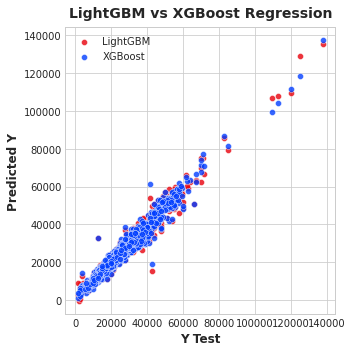

In [88]:
plt.figure(figsize = (5,5))
sns.scatterplot(x=y_test, y=y_pred_lgbm, label='LightGBM', alpha=0.8, color='r')
sns.scatterplot(x=y_test, y=y_pred_xgb, label='XGBoost',alpha=0.8, color='b')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.legend(loc='upper left')
plt.title('LightGBM vs XGBoost Regression')

In [89]:
print("RMSE using LightGBM: {} $".format(np.round(np.sqrt(MSE(y_pred_lgbm,y_test)),2)))
print("RMSE using XGBoost: {} $".format(np.round(np.sqrt(MSE(y_pred_xgb,y_test)),2)))

RMSE using LightGBM: 2214.26 $
RMSE using XGBoost: 2176.82 $


In [90]:
print("R2 using LightGBM: {} % ".format(np.round(r2_score(y_test, y_pred_lgbm)*100,2)))
print("R2 using XGBoost: {} % ".format(np.round(r2_score(y_test, y_pred_xgb)*100,2)))

R2 using LightGBM: 96.25 % 
R2 using XGBoost: 96.37 % 


By looking at the RMSE and R2 scores, we can see that LightGBM performs slightly better than XGBoost.

# Feature Importance

I will create dataframe to host the feature names and importance from XGBoost

In [91]:
xgb_model.feature_names = encoded_df.drop('price', axis = 1).columns

In [92]:
feat_df= pd.DataFrame({'feature': xgb_model.feature_names,'importance':xgb_model.feature_importances_})

Then, I will sort it by 'importance', creating a new sorted dataframe by importance

In [93]:
sorted_df=feat_df.sort_values('importance', ascending=False)

Then I can get the top 10 most important features:

Text(0.5, 0, 'Feature Importance (%)')

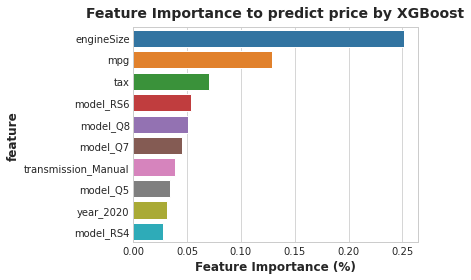

In [94]:
sns.barplot(x='importance', y='feature', data=sorted_df.head(10))
plt.title('Feature Importance to predict price by XGBoost')
plt.xlabel('Feature Importance (%)')

It is interesting to notice that there are 3 vehicle names in the top features and other encoded features. This is due to the use of one hot encoding.

We could exclude car names and check which would be then the top 10 features. We will check the presence of 'model' in the feature column by using a regex

In [95]:
feat_df2 = feat_df[~feat_df['feature'].astype(str).str.match("model")]

Then, as before, we create a new dataframe.

In [96]:
sorted_df2=feat_df2.sort_values('importance', ascending=False)

Text(0, 0.5, '')

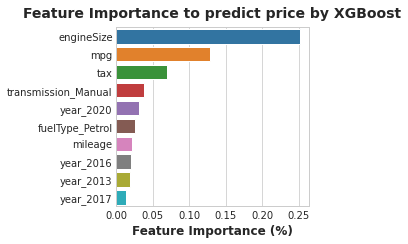

In [97]:
plt.figure(figsize=(4.5,3.5))
sns.barplot(x='importance', y='feature', data=sorted_df2.head(10))
plt.title('Feature Importance to predict price by XGBoost')
plt.xlabel('Feature Importance (%)')
plt.ylabel('')

It looks like enginesize and mpg are the most important factors to predict the price.

Moreover, the SHAP library will be used to get some more feature importance plots.

# Feature Importance by SHAP

In [98]:
xgb_explainer = shap.TreeExplainer(
    xgb_model, X_train, feature_names = encoded_df.drop('price', axis = 1).columns)

In [99]:
shap_values = xgb_explainer.shap_values(X_train, y_train)

100%|===================| 7870/7903 [02:22<00:00]        

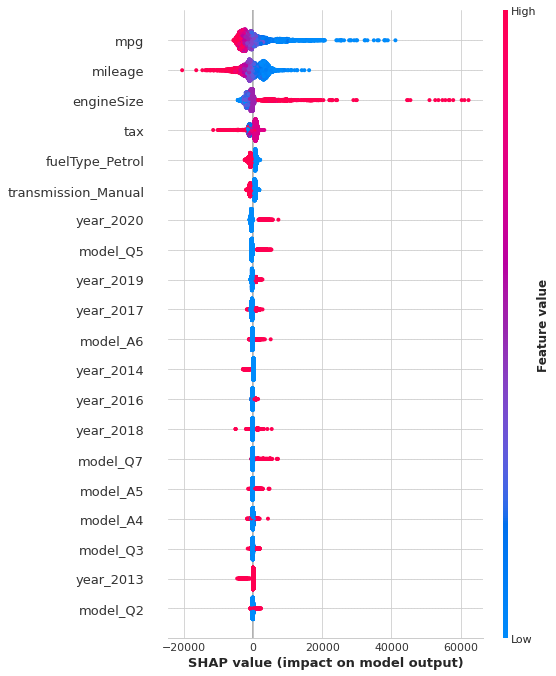

In [100]:
shap.summary_plot(shap_values, X_train, feature_names=encoded_df.drop('price', axis = 1).columns);

By looking at this plot, we can see more clearly the each feature effect on the predicted price. It is interesting to notice that as expected, mileage and tax, which both has a quite high high importance, have a negative impact: this means that cars with high tax and mileage tends to be sold for a lower price.<br>
On the other hand, cars with a high enginesize or mpg tends to be sold for a higher price.

**Thanks for reading my notebook ! Let me know if you have questions or if you want me to check out your works !!**